In [51]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch

from load_data import load_h5py_file

In [10]:
path = "./brain-to-text-25/t15_copyTask_neuralData/hdf5_data_final"
folders = os.listdir(path)
train_files = []
test_files = []
val_files = []
for i, files in enumerate(folders):
    files = os.listdir(os.path.join(path, files))
    for file in files:
        if file.endswith("train.hdf5"):
            train_files.append(os.path.join(path, folders[i], file))
        elif file.endswith("test.hdf5"):
            test_files.append(os.path.join(path, folders[i], file))
        elif file.endswith("val.hdf5"):
            val_files.append(os.path.join(path, folders[i], file))

In [11]:
train_df = pd.DataFrame()
for file in tqdm(train_files, desc="Loading train files"):
    data = load_h5py_file(file)
    temp_df = pd.DataFrame(data)
    train_df = pd.concat([train_df, temp_df], ignore_index=True)

val_df = pd.DataFrame()
for file in tqdm(val_files, desc="Loading val files"):
    data = load_h5py_file(file)
    temp_df = pd.DataFrame(data)
    val_df = pd.concat([val_df, temp_df], ignore_index=True)

test_df = pd.DataFrame()
for file in tqdm(test_files, desc="Loading test files"):
    data = load_h5py_file(file)
    temp_df = pd.DataFrame(data)
    test_df = pd.concat([test_df, temp_df], ignore_index=True)

Loading train files:   0%|          | 0/45 [00:00<?, ?it/s]

Loading val files:   0%|          | 0/41 [00:00<?, ?it/s]

Loading test files:   0%|          | 0/41 [00:00<?, ?it/s]

In [12]:
train_df.head()

,neural_features,n_time_steps,seq_class_ids,seq_len,transcriptions,sentence_label,session,block_num,trial_num
0,"[[-0.23488846, 0.5014211, -0.75813776, -0.5213...",544,"[6, 40, 36, 17, 21, 40, 15, 25, 40, 12, 5, 23,...",14,"[73, 32, 119, 105, 108, 108, 32, 103, 111, 32,...",I will go around.,t15.2023.11.03,1,0
1,"[[-0.23703846, 0.3616628, -0.7747983, 0.937466...",641,"[6, 40, 2, 22, 40, 31, 4, 20, 17, 24, 40, 31, ...",24,"[73, 32, 97, 109, 32, 116, 97, 108, 107, 105, ...",I am talking to my family.,t15.2023.11.03,1,1
2,"[[-0.23900536, -0.8310198, -0.75461406, -0.489...",694,"[17, 31, 40, 17, 38, 40, 21, 33, 20, 17, 24, 4...",22,"[73, 116, 32, 105, 115, 32, 108, 111, 111, 107...",It is looking quite hard.,t15.2023.11.03,1,2
3,"[[-0.24192314, 0.2851043, -0.7366848, -0.48644...",691,"[36, 6, 40, 9, 25, 23, 31, 40, 37, 34, 40, 20,...",19,"[87, 104, 121, 32, 100, 111, 110, 39, 116, 32,...",Why don't you come here.,t15.2023.11.03,1,3
4,"[[-0.24300373, -0.8231351, -0.71545774, -0.482...",918,"[6, 40, 37, 34, 39, 3, 36, 3, 21, 18, 40, 15, ...",29,"[73, 32, 117, 115, 117, 97, 108, 108, 121, 32,...",I usually go home by this time.,t15.2023.11.03,1,4


# CHeck for missing values

In [119]:
print("Missing values in train_df:")
print(train_df.isnull().sum())
print("\nMissing values in val_df:")
print(val_df.isnull().sum())
print("\nMissing values in test_df:")
print(test_df.isnull().sum())

Missing values in train_df:
neural_features    0
n_time_steps       0
seq_class_ids      0
seq_len            0
transcriptions     0
sentence_label     0
session            0
block_num          0
trial_num          0
dtype: int64

Missing values in val_df:
neural_features    0
n_time_steps       0
seq_class_ids      0
seq_len            0
transcriptions     0
sentence_label     0
session            0
block_num          0
trial_num          0
dtype: int64

Missing values in test_df:
neural_features       0
n_time_steps          0
seq_class_ids      1450
seq_len            1450
transcriptions     1450
sentence_label     1450
session               0
block_num             0
trial_num             0
dtype: int64


# Analyze the distribution of sentence lengths in train_df

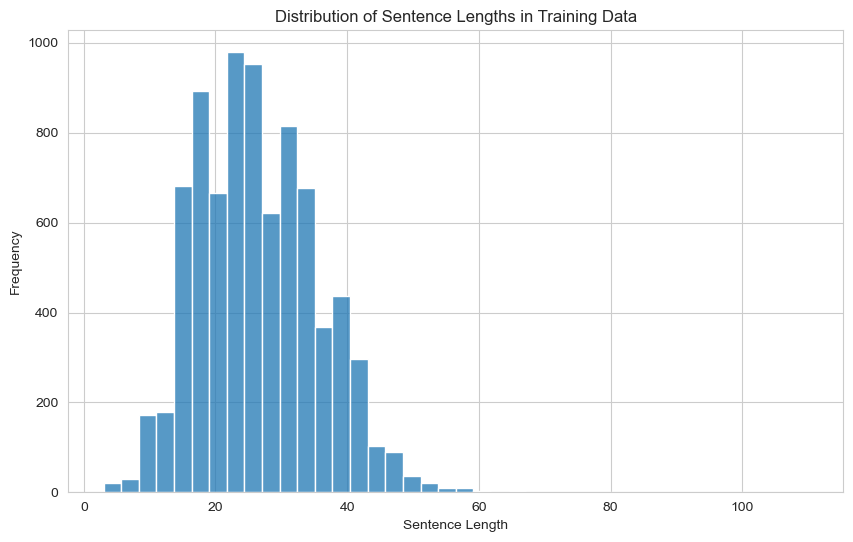

count    8072.000000
mean       26.541625
std         9.154736
min         3.000000
25%        20.000000
50%        26.000000
75%        33.000000
max       110.000000
Name: seq_len, dtype: float64


In [13]:
# plot distribution of sentence lengths in train_df
plt.figure(figsize=(10, 6))
sns.histplot(train_df['seq_len'], bins=40)
plt.title('Distribution of Sentence Lengths in Training Data')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.show()
print(train_df['seq_len'].describe())

# Analyze the distribution of the phoneme

In [14]:
# There are a lot of 0 at the end of seq_class_ids, remove them (e.g. [1, 2, 3, 0, 0, 0] -> [1, 2, 3])
# But keep the 0 in the middle (e.g. [1, 0, 2, 3, 0, 0, 0, 0, 0] -> [1, 0, 2, 3])
train_df_corr = train_df.copy()
val_df_corr = val_df.copy()
train_df_corr['seq_class_ids'] = train_df_corr['seq_class_ids'].apply(lambda x: x[:train_df_corr['seq_len'].iloc[0]])
val_df_corr['seq_class_ids'] = val_df_corr['seq_class_ids'].apply(lambda x: x[:val_df_corr['seq_len'].iloc[0]])

train_df_corr.head()

,neural_features,n_time_steps,seq_class_ids,seq_len,transcriptions,sentence_label,session,block_num,trial_num
0,"[[-0.23488846, 0.5014211, -0.75813776, -0.5213...",544,"[6, 40, 36, 17, 21, 40, 15, 25, 40, 12, 5, 23,...",14,"[73, 32, 119, 105, 108, 108, 32, 103, 111, 32,...",I will go around.,t15.2023.11.03,1,0
1,"[[-0.23703846, 0.3616628, -0.7747983, 0.937466...",641,"[6, 40, 2, 22, 40, 31, 4, 20, 17, 24, 40, 31, ...",24,"[73, 32, 97, 109, 32, 116, 97, 108, 107, 105, ...",I am talking to my family.,t15.2023.11.03,1,1
2,"[[-0.23900536, -0.8310198, -0.75461406, -0.489...",694,"[17, 31, 40, 17, 38, 40, 21, 33, 20, 17, 24, 4...",22,"[73, 116, 32, 105, 115, 32, 108, 111, 111, 107...",It is looking quite hard.,t15.2023.11.03,1,2
3,"[[-0.24192314, 0.2851043, -0.7366848, -0.48644...",691,"[36, 6, 40, 9, 25, 23, 31, 40, 37, 34, 40, 20,...",19,"[87, 104, 121, 32, 100, 111, 110, 39, 116, 32,...",Why don't you come here.,t15.2023.11.03,1,3
4,"[[-0.24300373, -0.8231351, -0.71545774, -0.482...",918,"[6, 40, 37, 34, 39, 3, 36, 3, 21, 18, 40, 15, ...",29,"[73, 32, 117, 115, 117, 97, 108, 108, 121, 32,...",I usually go home by this time.,t15.2023.11.03,1,4


In [19]:
LOGIT_TO_PHONEME = [
    'BLANK',    # "BLANK" = CTC blank symbol
    'AA', 'AE', 'AH', 'AO', 'AW',
    'AY', 'B', 'CH', 'D', 'DH',
    'EH', 'ER', 'EY', 'F', 'G',
    'HH', 'IH', 'IY', 'JH', 'K',
    'L', 'M', 'N', 'NG', 'OW',
    'OY', 'P', 'R', 'S', 'SH',
    'T', 'TH', 'UH', 'UW', 'V',
    'W', 'Y', 'Z', 'ZH',
    ' | ',    # "|" = silence token
]

# Flatten all phoneme IDs into a single array
all_phoneme_ids = np.concatenate(train_df_corr['seq_class_ids'].values)
train_phoneme_counts = np.bincount(all_phoneme_ids, minlength=len(LOGIT_TO_PHONEME))

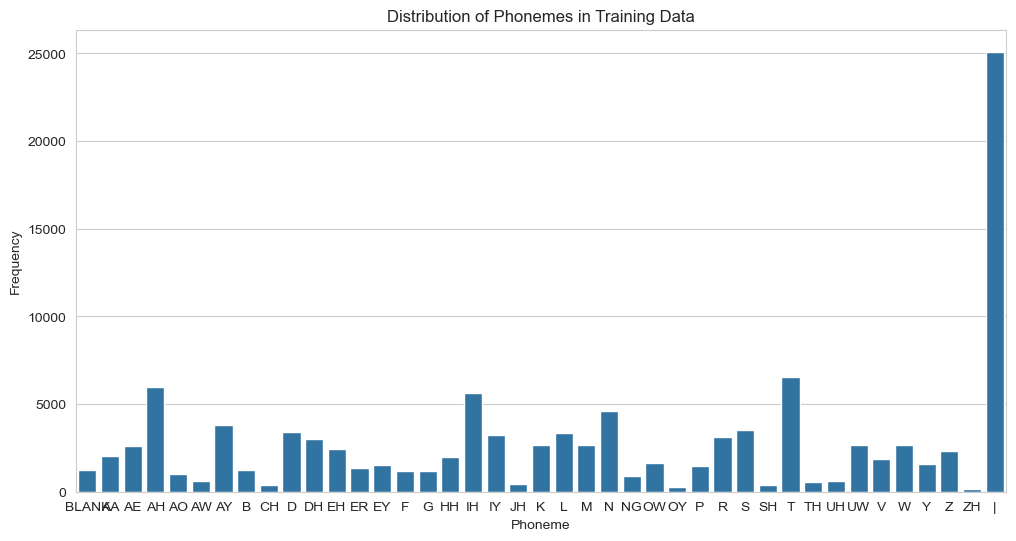

In [22]:
# plot distribution of phonemes in train_df
plt.figure(figsize=(12, 6))
sns.barplot(x=LOGIT_TO_PHONEME, y=train_phoneme_counts)
plt.title('Distribution of Phonemes in Training Data')
plt.xlabel('Phoneme')
plt.ylabel('Frequency')
plt.show()

# Analysis of the neural activation for each Brain region

In [120]:
print(train_df.neural_features[0][:, 0:64].mean())
print(train_df.neural_features[0][:, 64:128].mean())
print(train_df.neural_features[0][:, 128:192].mean())
print(train_df.neural_features[0][:, 192:256].mean())
print(train_df.neural_features[0][:, 256:320].mean())
print(train_df.neural_features[0][:, 320:384].mean())
print(train_df.neural_features[0][:, 384:448].mean())
print(train_df.neural_features[0][:, 448:512].mean())

-4.7213016e-05
-5.797976e-06
-5.149447e-05
-9.896212e-05
-1.0518467e-08
3.3308478e-08
6.4863876e-08
-1.7443124e-07


In [75]:
# The first (0-64) numbers are ventral 6v threshold, (65-128) area 4 threshold, (129-192) ...
FEATURE_MAP = {
    'ventral_6v_thresh': list(range(0, 64)),
    'area_4_thresh': list(range(64, 128)),
    'area_55b_thresh': list(range(128, 192)),
    'dorsal_6v_thresh': list(range(192, 256)),
    'ventral_6v_sbp': list(range(256, 320)),
    'area_4_sbp': list(range(320, 384)),
    'area_55b_sbp': list(range(384, 448)),
    'dorsal_6v_sbp': list(range(448, 512)),
}

# Calculate the mean activation for each brain region
region_means = {}
limit = 1000  # Select a random 1000 samples from train_df to speed up the process
train_df_sampled = train_df.sample(n=limit, random_state=42).reset_index(drop=True)
for region, indices in FEATURE_MAP.items():
    for features in tqdm(train_df_sampled.neural_features, desc=f"Processing {region}"):
        if region not in region_means:
            region_means[region] = []
        region_means[region].append(features[:, indices].mean())

Processing ventral_6v_thresh:   0%|          | 0/1000 [00:00<?, ?it/s]

Processing area_4_thresh:   0%|          | 0/1000 [00:00<?, ?it/s]

Processing area_55b_thresh:   0%|          | 0/1000 [00:00<?, ?it/s]

Processing dorsal_6v_thresh:   0%|          | 0/1000 [00:00<?, ?it/s]

Processing ventral_6v_sbp:   0%|          | 0/1000 [00:00<?, ?it/s]

Processing area_4_sbp:   0%|          | 0/1000 [00:00<?, ?it/s]

Processing area_55b_sbp:   0%|          | 0/1000 [00:00<?, ?it/s]

Processing dorsal_6v_sbp:   0%|          | 0/1000 [00:00<?, ?it/s]

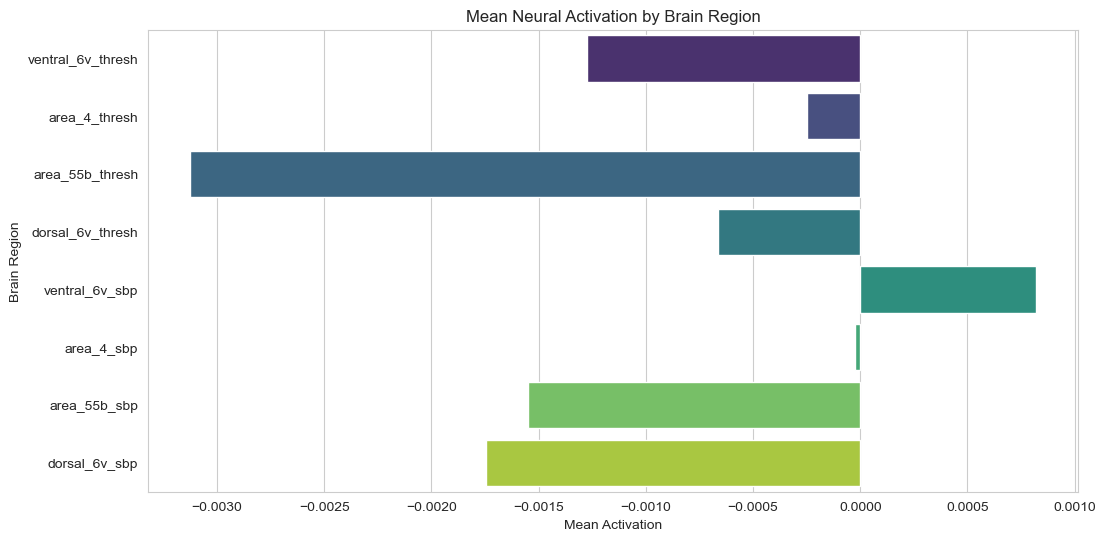

In [77]:
# Plot the mean activation for each brain region
plt.figure(figsize=(12, 6))
region_names = list(region_means.keys())
mean_activations = [np.mean(region_means[region]) for region in region_names]
sns.barplot(x=mean_activations, y=region_names, palette="viridis")
plt.title('Mean Neural Activation by Brain Region')
plt.xlabel('Mean Activation')
plt.ylabel('Brain Region')
plt.show()

## Brain zone activation heatmap for a single sentence

This allows us to visualize how different brain regions are activated over time while processing a single sentence.

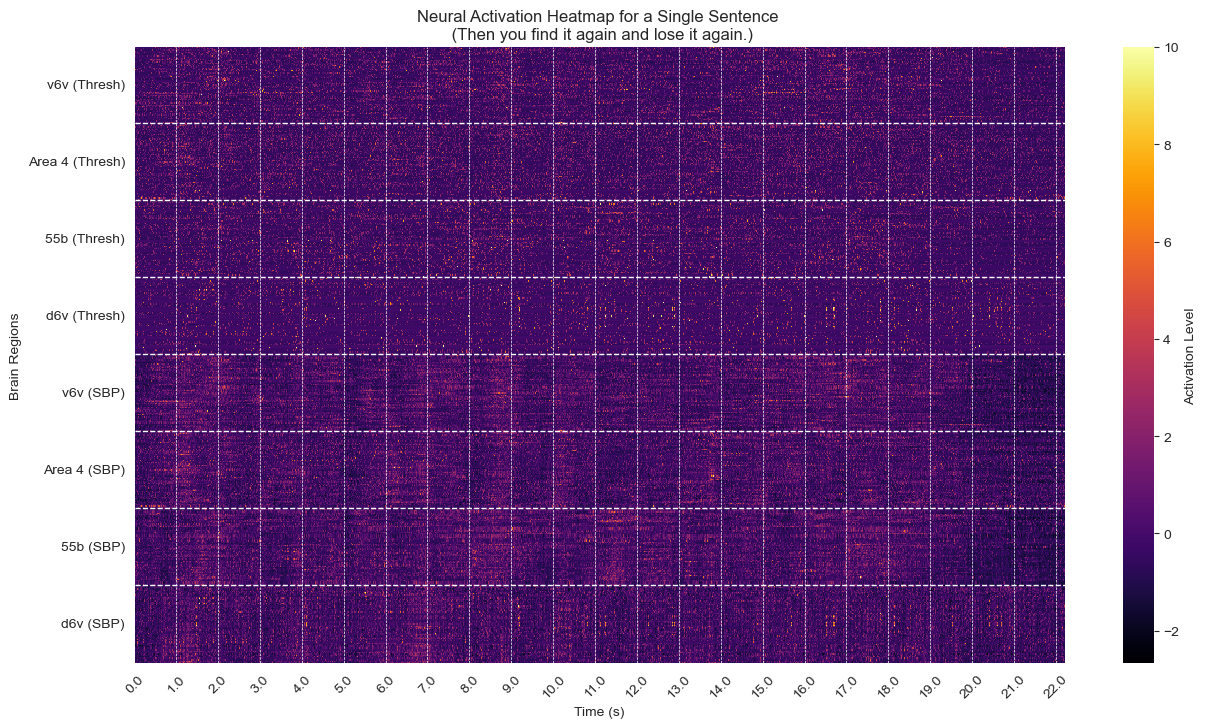

In [126]:
# Select a random sample from train_df
sample_idx = np.random.randint(0, len(train_df))
sample = train_df.iloc[sample_idx]
neural_data = sample['neural_features']
time_in_seconds = np.arange(neural_data.shape[0]) * 0.02

plt.subplots(figsize=(15, 8))
sns.heatmap(neural_data.T, cmap='inferno', cbar_kws={'label': 'Activation Level'})
plt.xticks(
        ticks=np.arange(0, neural_data.shape[0], 50),
        labels=np.round(time_in_seconds[np.arange(0, neural_data.shape[0], 50)], 2),
        rotation=45
    )
plt.yticks(
        ticks=[32, 96, 160, 224, 288, 352, 416, 480],
        labels=[
            'v6v (Thresh)', 'Area 4 (Thresh)', '55b (Thresh)', 'd6v (Thresh)',
            'v6v (SBP)', 'Area 4 (SBP)', '55b (SBP)', 'd6v (SBP)'
        ],
        rotation=0
    )
for i in [64, 128, 192, 256, 320, 384, 448]:
        plt.axhline(y=i-0.5, color='white', linestyle='--', linewidth=1)
for i in range(0, neural_data.shape[0], 50):
        plt.axvline(x=i-0.5, color='white', linestyle='--', linewidth=0.5)
plt.title(f'Neural Activation Heatmap for a Single Sentence \n ({sample["sentence_label"]})')
plt.xlabel('Time (s)')
plt.ylabel('Brain Regions')
plt.show()